## IMPORTANTO BIBLIOTECAS

In [1]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing import image
from tensorflow import keras

import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import os

## PARÂMETROS

In [2]:
percentege_test_size = 0.2
undersampling_size = 1300 # -1 para não fazer undersampling

# fig preprocessing
largura = 100
altura = 100
modo_de_cor = 'rgb' # rgb, grayscale, rgba
# fig preprocessing

# diretorio = '../dados classificacao imagens/star-wars/'
# diretorio = '../dados classificacao imagens/animais-kaggle/'
# diretorio = '../dados classificacao imagens/dataset-documentos-full/'
diretorio = '../dados classificacao imagens/pneumonia/'

### CARREGANDO DATASET

In [3]:
targets = [x[0].replace(diretorio,'') for x in os.walk(diretorio)]

targets = targets[1:len(targets)] # exclui o primeiro da lista pq é o próprio diretório

dados = []

class_to_int = {}

k = 0

for classe in targets:
    imagens = os.listdir(diretorio+classe)
    i = 0
    class_to_int[classe] = k
    k+=1
    for img in imagens:
        i+=1
        
        if (not '.txt' in img) and (not 'segmentation' in img) and (not 'desktop.ini' in img):
            dados.append([diretorio+classe+'/'+img,class_to_int[classe]])
        
        if(i == undersampling_size and undersampling_size != -1):
            break

dados = np.array(dados)

np.random.shuffle(dados)
            
df_dados = pd.DataFrame(dados,columns=['image','target'])

df_dados['target'] = df_dados['target'].astype('int64', copy=False)

df_dados

,image,target
0,../dados classificacao imagens/pneumonia/NORMA...,0
1,../dados classificacao imagens/pneumonia/NORMA...,0
2,../dados classificacao imagens/pneumonia/NORMA...,0
3,../dados classificacao imagens/pneumonia/PNEUM...,1
4,../dados classificacao imagens/pneumonia/NORMA...,0
...,...,...
2595,../dados classificacao imagens/pneumonia/PNEUM...,1
2596,../dados classificacao imagens/pneumonia/PNEUM...,1
2597,../dados classificacao imagens/pneumonia/PNEUM...,1
2598,../dados classificacao imagens/pneumonia/NORMA...,0


In [4]:
df_dados['target'].value_counts()

0    1300
1    1300
Name: target, dtype: int64

## PREPARANDO DADOS

In [5]:
def embedding(img_path,largura,altura,modo_de_cor):
    img = image.load_img(img_path, target_size=(largura, altura),color_mode= modo_de_cor)
    embed = image.img_to_array(img)

    return embed

In [6]:
y_full = df_dados['target'].array.to_numpy()

X_full  = []
for x in dados:
    X_full.append(embedding(x[0],largura,altura,modo_de_cor))

X_full = np.array(X_full)


In [7]:
model_test_size = int(len(y_full) * percentege_test_size)

X_test, X_train = X_full[:model_test_size] / 255.0, X_full[model_test_size:] / 255.0
y_test, y_train = y_full[:model_test_size], y_full[model_test_size:]

## TREINANDO E VALIDANDO O MODELO

In [8]:
shape_entrada = (largura,altura,1)

if(modo_de_cor == 'rgb'):
    shape_entrada = (largura,altura,3)

if(modo_de_cor == 'rgba'):
    shape_entrada = (largura,altura,4)

model = keras.models.Sequential([
    
########## Conv
    
keras.layers.InputLayer(input_shape=shape_entrada),
keras.layers.Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'),
keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
keras.layers.Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'),
keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),
keras.layers.BatchNormalization(),
keras.layers.Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'),
keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
keras.layers.BatchNormalization(),
keras.layers.Flatten(),
keras.layers.Dense(units=100, activation='relu'),
keras.layers.Dense(units=100, activation='relu'),
keras.layers.Dropout(0.25),

    
keras.layers.Dense(len(np.unique(y_train)), activation="softmax")
])

2022-05-19 19:39:59.277478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 19:39:59.302441: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 19:39:59.302597: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-19 19:39:59.303120: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 25)      1900      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 25)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 25, 25, 50)        31300     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 50)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 50)        200       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 70)          31570     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 70)          0

In [10]:
model.compile(loss="sparse_categorical_crossentropy",
optimizer="adam",
metrics=["accuracy"])

In [11]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')]

callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, verbose=0, restore_best_weights=True))


history = model.fit(X_train, y_train, epochs=500,
                    validation_split=0.05,
                    callbacks=callbacks
                   )

2022-05-19 19:40:59.917662: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/500


2022-05-19 19:41:00.622131: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


62/62 [==============================] - 3s 13ms/step - loss: 0.2752 - accuracy: 0.8887 - val_loss: 0.5912 - val_accuracy: 0.5769
Epoch 2/500
62/62 [==============================] - 0s 7ms/step - loss: 0.1147 - accuracy: 0.9555 - val_loss: 1.4691 - val_accuracy: 0.5769
Epoch 3/500
62/62 [==============================] - 0s 8ms/step - loss: 0.0914 - accuracy: 0.9686 - val_loss: 1.6911 - val_accuracy: 0.5769
Epoch 4/500
62/62 [==============================] - 0s 7ms/step - loss: 0.0598 - accuracy: 0.9803 - val_loss: 1.4130 - val_accuracy: 0.5769
Epoch 5/500
62/62 [==============================] - 0s 8ms/step - loss: 0.0629 - accuracy: 0.9782 - val_loss: 1.1356 - val_accuracy: 0.6635
Epoch 6/500
62/62 [==============================] - 0s 7ms/step - loss: 0.0458 - accuracy: 0.9793 - val_loss: 1.4908 - val_accuracy: 0.6058
Epoch 7/500
62/62 [==============================] - 0s 7ms/step - loss: 0.0326 - accuracy: 0.9904 - val_loss: 0.3020 - val_accuracy: 0.9135
Epoch 8/500
62/62 [=====

## VALIDANDO DE FORMA MAIS ELABORADA

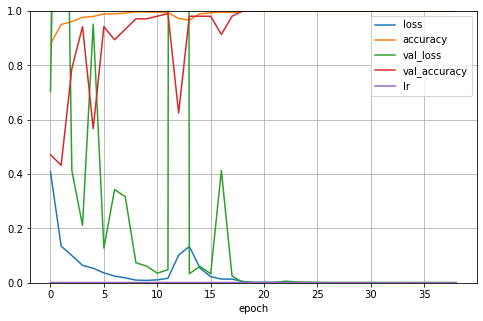

In [12]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.xlabel('epoch')
plt.show()

In [12]:
model.evaluate(X_test, y_test)

17/17 [==============================] - 0s 4ms/step - loss: 0.1602 - accuracy: 0.9692


[0.16023488342761993, 0.9692307710647583]

## VISUALIZANDO A MATRIZ DE CONFUSÃO

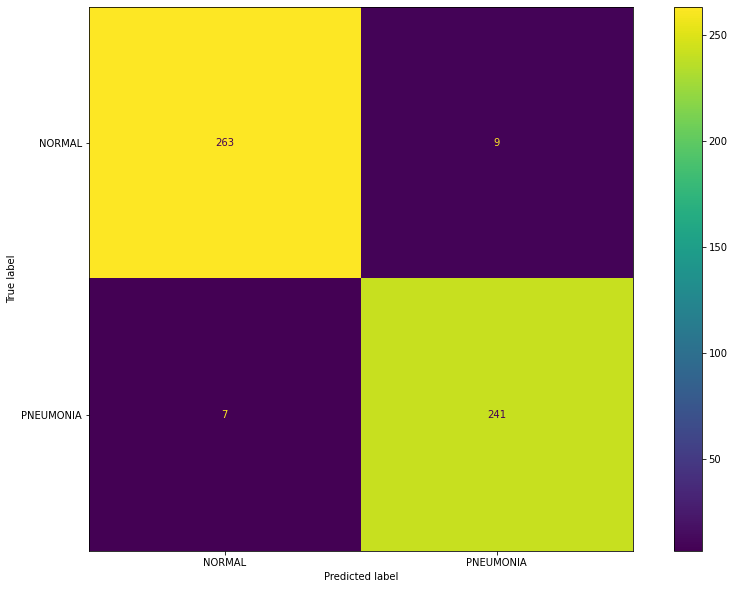

In [14]:
cm = confusion_matrix(y_test,np.argmax(model.predict(X_test), axis=-1))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_to_int)

plt.rcParams['figure.figsize'] = [15, 10]

disp.plot()

plt.show()